<a href="https://colab.research.google.com/github/joshiayush/ai/blob/svm/notebooks/projects/machine-learning/algorithms/svm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Support Vector Machines

An example of **SVM** in action.

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.metrics import (classification_report, confusion_matrix)
from sklearn.pipeline import make_pipeline
from sklearn.datasets import fetch_lfw_people
from sklearn.decomposition import PCA as RandomizedPCA
from sklearn.model_selection import (train_test_split, GridSearchCV)

In [ ]:
faces = fetch_lfw_people(min_faces_per_person=60, )

In [ ]:
faces.target_names, faces.images.shape

(array(['Ariel Sharon', 'Colin Powell', 'Donald Rumsfeld', 'George W Bush',
        'Gerhard Schroeder', 'Hugo Chavez', 'Junichiro Koizumi',
        'Tony Blair'], dtype='<U17'),
 (1348, 62, 47))

Let's plot these images to check what we're working with:

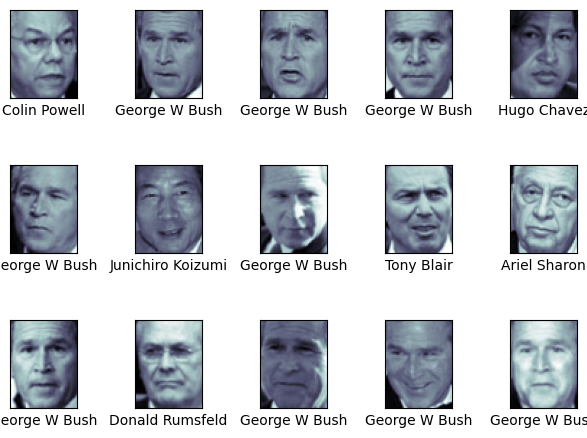

In [ ]:
fig, ax = plt.subplots(3, 5)
fig.tight_layout()
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='bone')
    axi.set(xticks=[], yticks=[], xlabel=faces.target_names[faces.target[i]])

Each image contains `[62×47]` or nearly `3,000` pixels. We could proceed by simply using each pixel value as a feature, but often it is more effective to use some sort of preprocessor to extract more meaningful features; here we will use a principal component analysis to extract 150 fundamental components to feed into our support vector machine classifier. We can do this most straightforwardly by packaging the preprocessor and the
classifier into a single pipeline:

In [ ]:
pca = RandomizedPCA(n_components=150, whiten=True, random_state=42)
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca, svc)

For the sake of testing our classifier output, we will split the data into a training and testing set:

In [ ]:
Xtrain, Xtest, ytrain, ytest = train_test_split(faces.data, faces.target, random_state=42)

In [ ]:
param_grid = {
    'svc__C': [1, 5, 10, 50],
    'svc__gamma': [0.0001, 0.0005, 0.001, 0.005],
}
grid = GridSearchCV(model, param_grid)

In [ ]:
%time grid.fit(Xtrain, ytrain)

CPU times: user 1min 5s, sys: 48 s, total: 1min 53s
Wall time: 1min 8s


GridSearchCV(estimator=Pipeline(steps=[('pca',
                                        PCA(n_components=150, random_state=42,
                                            whiten=True)),
                                       ('svc',
                                        SVC(C=5, class_weight='balanced',
                                            gamma=0.001))]),
             param_grid={'svc__C': [1, 5, 10, 50],
                         'svc__gamma': [1e-05, 0.0001, 0.0005, 0.001, 0.005]})

In [ ]:
grid.best_params_

{'svc__C': 5, 'svc__gamma': 0.001}

The optimal values fall toward the middle of our grid; if they fell at the edges, we would want to expand the grid to make sure we have found the true optimum.

Now with this cross-validated model, we can predict the labels for the test data, which the model has not yet seen:

In [ ]:
model = grid.best_estimator_
y_pred = model.predict(Xtest)

Let’s take a look at a few of the test images along with their predicted values

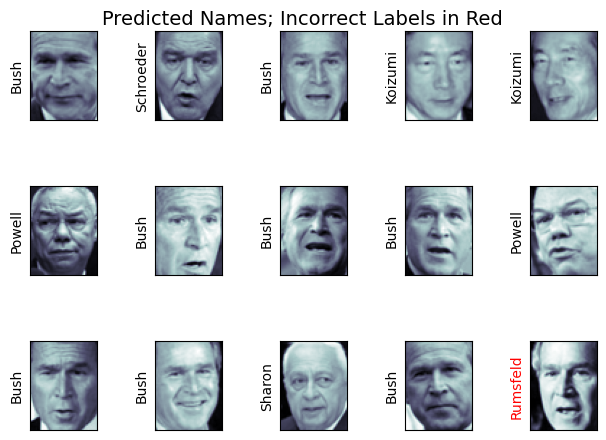

In [ ]:
fig, ax = plt.subplots(3, 5)
fig.tight_layout()
for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[y_pred[i]].split()[-1],
                   color='black' if y_pred[i] == ytest[i] else 'red')
fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14);

Let's list some recovery statistics label by label.

In [ ]:
print(classification_report(ytest, y_pred, target_names=faces.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.65      0.87      0.74        15
     Colin Powell       0.83      0.88      0.86        68
  Donald Rumsfeld       0.70      0.84      0.76        31
    George W Bush       0.97      0.80      0.88       126
Gerhard Schroeder       0.76      0.83      0.79        23
      Hugo Chavez       0.93      0.70      0.80        20
Junichiro Koizumi       0.86      1.00      0.92        12
       Tony Blair       0.82      0.98      0.89        42

         accuracy                           0.85       337
        macro avg       0.82      0.86      0.83       337
     weighted avg       0.86      0.85      0.85       337



Let's look at the confusion matrix between these classes:

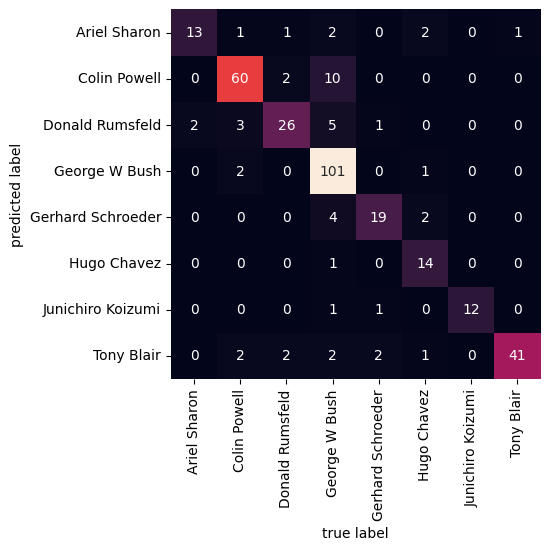

In [ ]:
mat = confusion_matrix(ytest, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=faces.target_names, yticklabels=faces.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');